In [1]:
pip install contextily

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


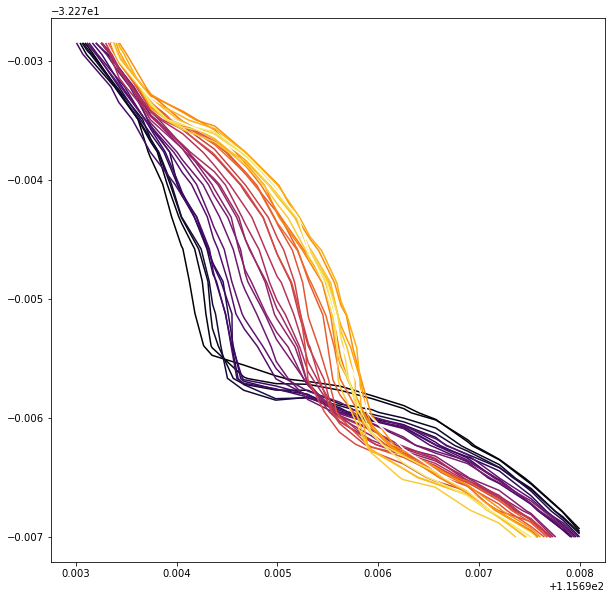

In [50]:
import geopandas as gpd
from shapely.geometry import box
import contextily as ctx
import pandas as pd
import matplotlib

# Get bounding box of data
site = 'barbeach'
offset=0
ymax, xmin = -32.94020, 151.75523
ymin, xmax = -32.95006, 151.77255

# # Get bounding box of data
# site = 'nobbys'
# offset=0
# ymax, xmin = -32.9178, 151.79070
# ymin, xmax = -32.926, 151.80284

# Get bounding box of data
site = 'capeperon'
offset=545
ymax, xmin = -32.2728511,115.6928997
ymin, xmax = -32.277,115.698

# Create bbox
bbox = gpd.GeoSeries(box(xmin, ymin, xmax, ymax), crs='EPSG:4326')

# # Set up WFS requests for annual coastlines & rates of change statistics
# deacl_coastlines_wfs = 'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
#                        'service=WFS&version=1.1.0&request=GetFeature&' \
#                        'typeName=dea:coastlines&maxFeatures=1000&' \
#                       f'bbox={ymin},{xmin},{ymax},{xmax},urn:ogc:def:crs:EPSG:4326'

# # Load data from WFS and set CRS
# deacl_gdf = gpd.read_file(deacl_coastlines_wfs)
# deacl_gdf.crs = 'EPSG:3577'

deacl_gdf = gpd.read_file('/g/data/r78/DEACoastlines/DEACoastlines_annualcoastlines_v1.1.1.shp', bbox=bbox)


# Clip to extent of satellite data
bbox = gpd.GeoDataFrame(geometry=bbox)  
deacl_gdf = gpd.overlay(deacl_gdf, bbox.to_crs(deacl_gdf.crs))
deacl_gdf = deacl_gdf.dissolve('year').to_crs('EPSG:4326')

# Apply colours
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(deacl_gdf.index))
cmap = matplotlib.cm.get_cmap('inferno')
rgba = cmap(norm(deacl_gdf.reset_index().index))
deacl_gdf['color'] = list(rgba)
deacl_gdf.at['2020', 'color'] = 'white'
deacl_gdf.plot(color=deacl_gdf['color'], figsize=(10, 10))

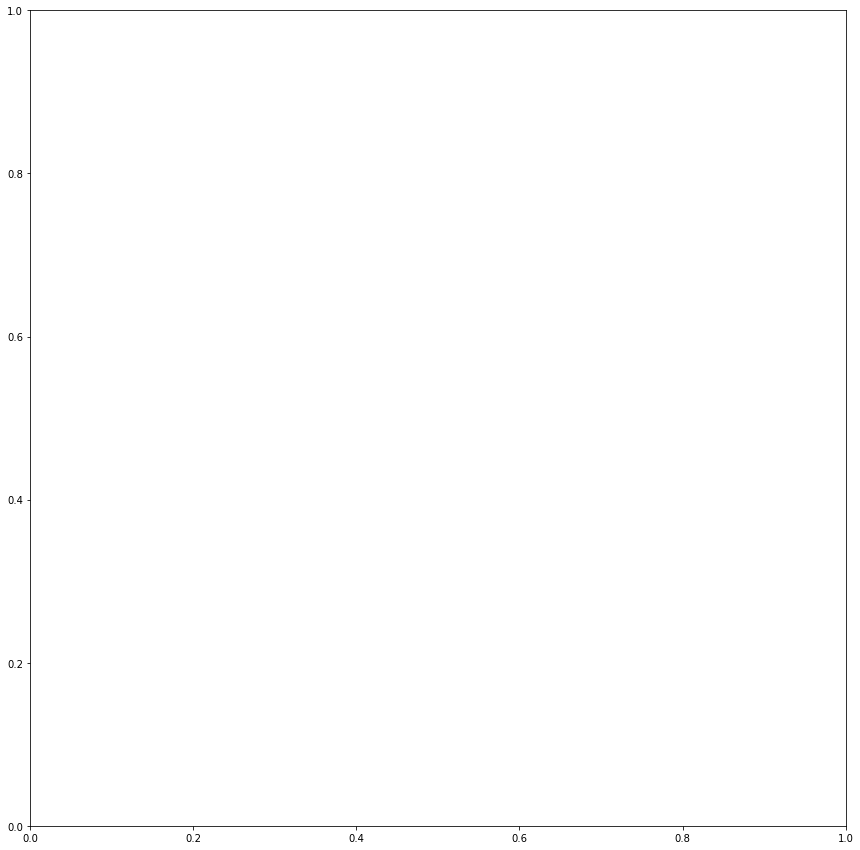

In [59]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

for i, year in enumerate(deacl_gdf.index):

    year_gdf = deacl_gdf.loc[[year]]
    year_gdf.plot(ax=ax, color='black', linewidth=3)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ctx.add_basemap(ax, 
                    source='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
                    crs='EPSG:4326',
                    alpha=0.85)
    ax.annotate('Median\nshoreline\nposition', xy=(710, 42 + offset), xycoords='axes points', size=20, ha='left', color='white')
    ax.annotate(year, xy=(500, 40 + offset), xycoords='axes points', size=80, color='white')
    ax.axis('off')
    plt.savefig(f'Frames/{site}_{year}.png',bbox_inches='tight',transparent=True, pad_inches=0, dpi=150)
    plt.cla()

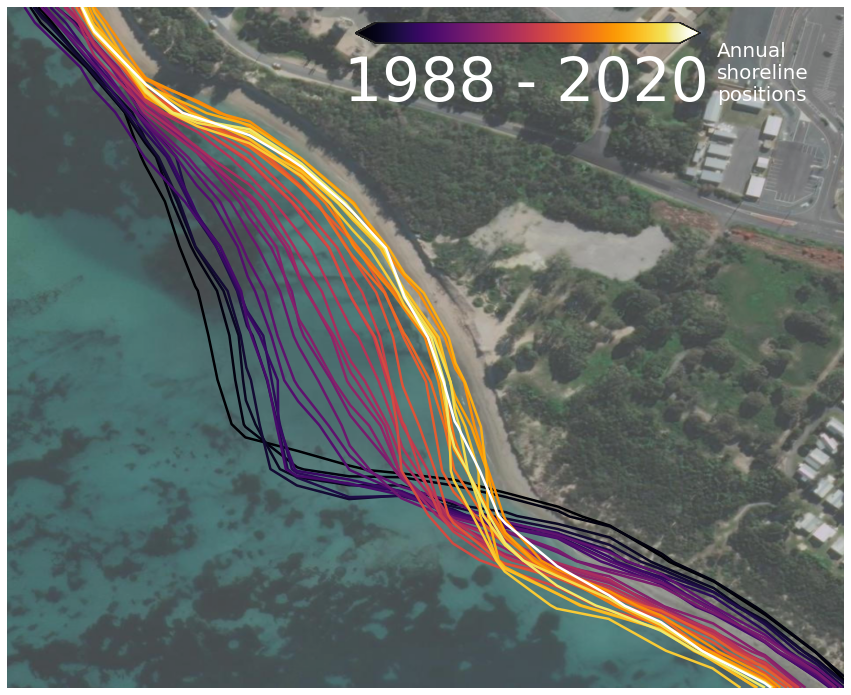

In [60]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.image import imread

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
deacl_gdf.plot(ax=ax, color=deacl_gdf.color, linewidth=2.5)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Add basemap
ctx.add_basemap(ax, 
                    source='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
                    crs='EPSG:4326',
                    alpha=0.85)
ax.annotate('Annual\nshoreline\npositions', xy=(710, 42 + offset), xycoords='axes points', size=20, ha='left', color='white')
ax.annotate('1988 - 2020', xy=(337, 42 + offset), xycoords='axes points', size=60, color='white')

# Add image overlay
arr_lena = imread('/g/data/r78/DEACoastlines/visualisation/images/DEACoastlines_key.png')
imagebox = OffsetImage(arr_lena, zoom=0.41)
ab = AnnotationBbox(imagebox, xy=(522, 110 + offset), xycoords='axes points', frameon=False)
ax.add_artist(ab)

ax.axis('off')
plt.savefig(f'Frames/{site}_2021.png',bbox_inches='tight',transparent=True, pad_inches=0, dpi=150)

In [61]:
!ffmpeg -y -r 1.5 -start_number 1988 -i Frames/{site}_%4d.png -c:v libx264 -vf "fps=1.5,format=yuv420p,pad=ceil(iw/2)*2:ceil(ih/2)*2" temp.mp4
!ffmpeg -y -i temp.mp4 -i /g/data/r78/DEACoastlines/visualisation/images/DEACoastlines_logo.png \
-filter_complex "[1:v]scale=360:220 [img], [0:v][img] overlay=0:0:enable='between(t,0,36)' [ovrl],[ovrl] split=3 [ovrl1][ovrl2][ovrl3],[ovrl1]trim=0:5[hold],[ovrl2][hold]concat[extended],[extended][ovrl3]overlay" \
-pix_fmt yuv420p -c:a copy \
deacoastlines_{site}_animation.mp4 
   
    

ffmpeg version 3.3.4-static http://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 6.4.0 (Debian 6.4.0-4) 20170820
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc-6 --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gray --enable-libfribidi --enable-libass --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-librtmp --enable-libsoxr --enable-libspeex --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libzimg
  libavutil      55. 58.100 / 55. 58.100
  libavcodec     57. 89.100 / 57. 89.100
  libavformat    57. 71.100 / 57. 71.100
  libavdevice    57.  6.100 / 57.  6.100
  libavfilter     6. 82.100 /  6.